In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg as LA
from numpy.random import default_rng
import pywt
import ham_cr

In [2]:
# generate a complete data set of {cV, \chi_z, M_z} for one set of random Stevens parameters
# Comment: we could think to make a class that generates a full set of N training data sets (from N random Stevens parameters - then N would be given to the class). Here, the random drawing of Stevens parameters happens outside the class. 

class training_data:
    """
    Class generates and output training data: specific_heat(T), susceptibility(T) and magnetization(T, B) along specified direction(s). 
    (Optional) parameters that can be provided at instantiation: 
        point_group: Point group defined form of crystal field Hamiltonian (set to 'Oh' per default)
        N_t: Number of training sets = number of randomly chosen Stevens parameter sets. (Set to 1 per default)
        rng_seed: seed of random number generator that draws Stevens parameters (set to 1 per default)
        J, L, S: angular momentum of ion (set to J=4, L=5, S=1 per default)
        B_directions: magnetic field directions that are considered in susc and mag (set to [[0,0,1]] per default)

    Functions: 
    """

    # Bohr magneton over Boltzmann constant
    # Used to transform magnetic field B from unitsof Tesla to units of Kelvin: [muB*B/k_B] = Kelvin with [B] = Tesla
    muB_over_kB = 0.671713816 

    def __init__(self, point_group = 'Oh', N_t = 1, rng_seed = 1, J = 4, L = 5, S = 1, B_directions = [[0,0,1]]):
        self.point_group = point_group
        self.N_t = N_t
        self.rng_seed = rng_seed
        self.rg = default_rng(rng_seed)
        self.J = J
        self.L = L
        self.S = S
        self.B_directions = B_directions

    ###### define angular momentum operators Jx_op, Jy_op, Jz_op for a given J value #####
    def Jz_op(self):
        mat = np.diag(np.arange(2*self.J+1,dtype=np.float) - self.J)
        return mat

    def Jplus_op(self):
        mat = np.diag(np.sqrt((2*self.J - np.arange(2*self.J))*(np.arange(2*self.J)+1)), -1)
        return mat

    def Jminus_op(self):
        mat = np.diag(np.sqrt((2*self.J - np.arange(2*self.J))*(np.arange(2*self.J)+1)), 1)
        return mat

    def Jx_op(self):
        mat = (self.Jplus_op() + self.Jminus_op())/2.
        return mat

    def Jy_op(self):
        mat = -1j/2.*(self.Jplus_op() - self.Jminus_op())
        return mat

    def gJLS(self):
        return 1 + (self.J*(self.J + 1) + self.S*(self.S+1) - self.L*(self.L+1))/(2*self.J*(self.J + 1))

    ####### Draw random Stevens paramaters #######################################

    def generate_random_stevens(self, range):
        """
        Generated random values for Stevens parameters for given point group. 

        Parameters: 
            ppoint_group: string of point group in Schoenflies notation
            range: array of ranges for Stevens parameters [[x0_min, x0_max], [x1_min, x1_max], ...] 
        Returns: 
            stevens_params: array with random instances of Stevens parameters
        """
        # TO DO: implement error messages if range is not correct: in particular, it will get stuck if the range of the x_1, ..., x_{N-1} is not given by [-1,1]
        if self.point_group == 'Oh': # two Stevens parameters for m-3m = Oh point group
            x0 = (range[0][0] + (range[0][1] - range[0][0])*self.rg.random())*self.rg.choice([-1,1])
            x1 = range[1][0] + (range[1][1] - range[1][0])*self.rg.random()
            stevens_params = np.array([x0, x1])
        elif self.point_group == "C4v": # 5 Stevens parameters for 4mm = C4v point group
            stevens_params = np.array([1.,1.,1.,1.,1., 0.])
            while (np.sum(np.abs(stevens_params)) - np.abs(stevens_params[0]) - np.abs(stevens_params[-1]) > 1):
                stevens_params[0] = (range[0][0] + (range[0][1] - range[0][0])*self.rg.random())*self.rg.choice([-1,1])
                stevens_params[1] = range[1][0] + (range[1][1] - range[1][0])*self.rg.random()
                stevens_params[2] = range[2][0] + (range[2][1] - range[2][0])*self.rg.random()
                stevens_params[3] = range[3][0] + (range[3][1] - range[3][0])*self.rg.random()
                stevens_params[4] = range[4][0] + (range[4][1] - range[4][0])*self.rg.random()
            stevens_params[5] = 2.*self.rg.random() - 1. # only sign of x5 matters as size is determined by x1, .., x4. 
        elif self.point_group == "D3h": # 4 Stevens parameters for -6m2 = D3h point group
            stevens_params = np.array([1.,1.,1.,1., 0.])
            while (np.sum(np.abs(stevens_params)) - np.abs(stevens_params[0]) - np.abs(stevens_params[-1]) > 1):
                stevens_params[0] = (range[0][0] + (range[0][1] - range[0][0])*self.rg.random())*self.rg.choice([-1,1])
                stevens_params[1] = range[1][0] + (range[1][1] - range[1][0])*self.rg.random()
                stevens_params[2] = range[2][0] + (range[2][1] - range[2][0])*self.rg.random()
                stevens_params[3] = range[3][0] + (range[3][1] - range[3][0])*self.rg.random()
            stevens_params[4] = 2.*self.rg.random() - 1. # only sign of x5 matters as size is determined by x1, .., x4. 
        else:
            raise ValueError("This point group is not implemented.")
        return stevens_params
            
    ####### Define the crystal field Hamiltonian for given point group and J ##########
    def ham_cr(self, stevens_params):
        """
        Outputs crystal field Hamiltonian H in units of Kelvin. The units of H are set by the units of x0. We choose the range of x0 (=[1,50] Kelvin) that corresponds to [x0] = Kelvin. 

        Parameters: 
            stevens_params: array of Stevens parameters (check that length is correct). x0 has dimensions of energy (we use Kelvin) and x1, x2, ... are dimensionless in interval [-1,1].
        Returns: 
            ham_cr: crystal field Hamiltonian array 
        """
        if (self.point_group == 'Oh'):  
            if (len(stevens_params) != 2): 
                raise ValueError("Number of Stevens parameters should be 2 for point group Oh")
            if (self.J == 4):
                return ham_cr.ham_cr_PG_Oh_J_4(stevens_params[0], stevens_params[1])
            elif (self.J == 7.5):
                return ham_cr.ham_cr_PG_Oh_J_7_5(stevens_params[0], stevens_params[1])
            elif (self.J == 3.5):
                return ham_cr.ham_cr_PG_Oh_J_3_5(stevens_params[0], stevens_params[1])
            elif (self.J == 6):
                return ham_cr.ham_cr_PG_Oh_J_6(stevens_params[0], stevens_params[1])
            elif (self.J == 8):
                return ham_cr.ham_cr_PG_Oh_J_8(stevens_params[0], stevens_params[1])
            elif (self.J == 4.5):
                return ham_cr.ham_cr_PG_Oh_J_4_5(stevens_params[0], stevens_params[1])
        elif (self.point_group == 'C4v'): 
            if (len(stevens_params) != 6): 
                raise ValueError("Number of Stevens parameters should be 5+1=6 for point group C4v")
            if (self.J == 4):
                return ham_cr.ham_cr_PG_C4v_J_4(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4], stevens_params[5])
            elif (self.J == 7.5):
                return ham_cr.ham_cr_PG_C4v_J_7_5(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4], stevens_params[5])
            elif (self.J == 3.5):
                return ham_cr.ham_cr_PG_C4v_J_3_5(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4], stevens_params[5])
            elif (self.J == 6):
                return ham_cr.ham_cr_PG_C4v_J_6(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4], stevens_params[5])
            elif (self.J == 8):
                return ham_cr.ham_cr_PG_C4v_J_8(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4], stevens_params[5])
            elif (self.J == 4.5):
                return ham_cr.ham_cr_PG_C4v_J_4_5(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4], stevens_params[5])

        elif (self.point_group == 'D3h'): 
            if (len(stevens_params) != 5): 
                raise ValueError("Number of Stevens parameters should be 4+1=5 for point group D3h")
            if (self.J == 4):
                return ham_cr.ham_cr_PG_D3h_J_4(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4])
            elif (self.J == 7.5):
                return ham_cr.ham_cr_PG_D3h_J_7_5(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4])
            elif (self.J == 3.5):
                return ham_cr.ham_cr_PG_D3h_J_3_5(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4])
            elif (self.J == 6):
                return ham_cr.ham_cr_PG_D3h_J_6(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4])
            elif (self.J == 8):
                return ham_cr.ham_cr_PG_D3h_J_8(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4])
            elif (self.J == 4.5):
                return ham_cr.ham_cr_PG_D3h_J_4_5(stevens_params[0], stevens_params[1], stevens_params[2], stevens_params[3], stevens_params[4])
        else: 
            raise ValueError("This point group and/or value of J is not implemented.")   

    ####### Calculate specific heat ##################################

    def specific_heat(self, ham, T_min=2, T_max=300, T_steps=150):
        """
        Returns array of cV/kB for a single rare-earth ion over temperature range [T_min, T_max] for hamiltonian matrix ham. Note that [cV/kB] is dimensionless. To get the specific heat, multiply the result with the Boltzmann constant kB. 

        Parameters: 
            ham : hermitian Hamiltonian matrix, typically of crystal field Hamiltonian (dimension 2*J+1)
            T_min : minimal temperature in Kelvin
            T_max : maximal temprature in Kelvin
            T_steps: total number of steps in temperature range

        Returns: 
            cV_array: cV/kB for a single rare-earth ion. Array of dimension (T_steps, 2) containing (T_i, cV/kB(T_i) ),             where T_i is temperature at step i 

        """  
        T = np.linspace(T_min, T_max, T_steps) # linearly spaced temperatures
        energies = LA.eigvalsh(ham)
        energies = energies - energies[0]

        # partition function for zero field
        def Z_cr(T):
            return np.sum(np.exp(-energies/T))
        
        # specific heat expression
        def cV(T):
            return 1./(T**2) * (np.sum(energies**2 * np.exp(-energies/T))/Z_cr(T) - np.sum(energies * np.exp(-energies/T)/Z_cr(T))**2)

        cV_array = np.zeros((len(T), 2))

        #this can probably be optimized using numpy ufuncs, but it is ok for now
        for i in range(0, len(cV_array)):
            cV_array[i][0] = T[i]
            cV_array[i][1] = cV(T[i])
    
        return cV_array

    ######### Calculate magnetization ##############################

    def magnetization(self, ham_cr, B_direction, B_min=0, B_max=10, B_steps=20, T_min=2, T_max=300, T_steps=4):
        """
        Returns array of moment per R-ion mu/mu_B (over mu_B) over temperature and magnetic field range [T_min, T_max] and [B_min, B_max] for a system with zero-field Hamiltonian matrix ham_cr. Note mu/mu_B is dimensionless. The magnetic field is along B_direction (x, y, z).  
        Parameters: 
            ham_cr : hermitian Hamiltonian matrix in zero field, typically of crystal field Hamiltonian (dimension 2*J+1)
            B_direction: (B_x, B_y, B_z) triple denoting the field direction in real space
            B_min: minimal field (in Tesla)
            B_max: maximal field (in Tesla)
            B_steps: total number of steps in field range
            T_min : minimal temperature in Kelvin
            T_max : maximal temprature in Kelvin
            T_steps: total number of steps in temperature range

        Returns: 
            mag_array: induced moment on R-ion mu/muB in array of dimension (T_steps, B_steps, 2) containing (B_i, T_i, mag(B_i, T_i) ), where T_i (B_i) is temperature (field) at step i. Note that this differs by a factor of gJLS from a previous version of the function. 

        """  
        gJLS = float(self.gJLS())

        T_array = np.geomspace(T_min, T_max, T_steps)
        B_array = np.linspace(B_min, B_max, B_steps)

        B_direction = B_direction/LA.norm(B_direction)
        J_op = B_direction[0]*self.Jx_op() + B_direction[1]*self.Jy_op() + B_direction[2]*self.Jz_op()

        mag_array = np.zeros((len(B_array), len(T_array), 3))

        # this can probably be optimized using numpy ufuncs, but it is ok for now
        for B_idx in np.arange(0, len(B_array)):
            B = B_array[B_idx]
            ham = ham_cr - gJLS*self.muB_over_kB*J_op*B
            energies, eigenstates = LA.eigh(ham)
            energies = energies - energies[0]
            
            for T_idx in range(0, len(T_array)):
                T = T_array[T_idx]
                ZB = np.sum(np.exp(-energies/T))
                # mag = \mu/\mu_B is moment per R-ion over Bohr magneton. mag is dimensionless. 
                mag = gJLS/ZB*np.sum([np.dot(np.conjugate(eigenstates[:,i]), np.dot(J_op, eigenstates)[:, i])*np.exp(-energies[i]/T) for i in range(0, len(energies))])
    
                mag_array[B_idx][T_idx][0] = B_array[B_idx]
                mag_array[B_idx][T_idx][1] = T_array[T_idx]
                mag_array[B_idx][T_idx][2] = mag

        return mag_array
    
    ########### Calculate magnetic susceptibility ############################
    
    def susceptibility(self, ham_cr, B_direction, B=0.0001, T_min=1, T_max=300, T_steps=300):
        """
        Calculated and returns magnetic susceptibility chi_a = mu/(mu_B*B) (units of 1/T) over temperature range [T_min, T_max] for zero-field Hamiltonian matrix ham_cr. Here, mu is the induced moment on the R-ion, mu_B is the Bohr magneton and B the magnetic field. The direction is a=B_direction .
        Parameters: 
            ham_cr : hermitian Hamiltonian matrix in zero field, typically a crystal field Hamiltonian (dimension 2*J+1)
            B_direction: (B_x, B_y, B_z) triple denoting the field direction in real space
            B: B field used in susceptibility calculation (in Tesla). Should be << all other energy scales. 
            T_min : minimal temperature in Kelvin
            T_max : maximal temprature in Kelvin
            T_steps: total number of steps in temperature range
            
        Returns: 
            susc_array: array of dimension (T_steps, 2) containing (T_i, mu(T_i)/(muB*B), where T_i is temperature at step i and mu(T_i)/mu_B = mag(T_i) is the field induced moment on the R-ion. Note that this differs by a factor of gJLS from a previous version of the function. 

        """  
        gJLS = float(self.gJLS())

        T_array = np.linspace(T_min, T_max, T_steps)

        B_direction = B_direction/LA.norm(B_direction)
        J_op = B_direction[0]*self.Jx_op() + B_direction[1]*self.Jy_op() + B_direction[2]*self.Jz_op()

        susc_array = np.zeros((len(T_array), 2))

        # this can probably be optimized using numpy ufuncs, but it is ok for now  
        # B is given in units of T, ham is in units of K.
        ham = ham_cr - gJLS*self.muB_over_kB*J_op*B
        energies, eigenstates = LA.eigh(ham)
        energies = energies - energies[0]
            
        for T_idx in range(0, len(T_array)):
                T = T_array[T_idx]
                ZB = np.sum(np.exp(-energies/T))
                # mag = mu/mu_B, where \mu is the field induced moment on the R-ion
                mag = gJLS/ZB*np.sum([np.dot(np.conjugate(eigenstates[:,i]), np.dot(J_op, eigenstates)[:, i])*np.exp(-energies[i]/T) for i in range(0, len(energies))])

                susc_array[T_idx][0] = T_array[T_idx]
                # susc = mag/B = \mu/(\mu_B B) has units of 1/T
                susc_array[T_idx][1] = mag/B 

        return susc_array

    ######## Output training data into files #################

    def output_all_data(self, Stevens_range, cV_T_range = [1, 300, 100], susc_T_range = [1, 300, 100], mag_T_range = [1, 300, 4], mag_B_range = [0.5, 10, 20]):
        """
        Write training data to file
        Parameters: 
            cV_T_range: [T_min, T_max, T_steps] array for specific heat calculation
        Returns: 

        """
        stevens_params_all = [] 
        cV_data_all = []
        susc_data_all = []
        mag_data_all = []
        for N_t_idx in range(0, self.N_t):
            if (N_t_idx % 1000 == 0):
                print('.', end='')
                
            stevens_params = self.generate_random_stevens(Stevens_range) # draw random Stevens parameters
            stevens_params_all.append(stevens_params) # use a list to store all Stevens parameters. Since different point groups have different number of Stevens parameters, the tuples that are stored have different length. 
            ham_cr = self.ham_cr(stevens_params) # crystal field Hamiltonian for given random Stevens parameters

            # generate specific heat data and store in cV_data
            cV_data_all.append(self.specific_heat(ham_cr, T_min = cV_T_range[0], T_max = cV_T_range[1], T_steps = cV_T_range[2]))

            B_direction_steps = len(self.B_directions)

            # generate susceptibility data and store in susc_data (for all B_directions)
            susc_data = np.zeros((susc_T_range[2], 1 + B_direction_steps))
            mag_data = np.zeros((mag_B_range[2], mag_T_range[2], 2 + B_direction_steps))
            
            for B_direction_idx in range (0, B_direction_steps):
                B_direction = self.B_directions[B_direction_idx]
                susc_array = self.susceptibility(ham_cr, B_direction, B = 0.001, T_min = susc_T_range[0], T_max = susc_T_range[1], T_steps = susc_T_range[2])
                mag_array = self.magnetization(ham_cr, B_direction, B_min = mag_B_range[0], B_max = mag_B_range[1], B_steps = mag_B_range[2], T_min = mag_T_range[0], T_max = mag_T_range[1], T_steps = mag_T_range[2])

                for T_idx in range (0, len(susc_array)):
                    if (B_direction_idx == 0): 
                        susc_data[T_idx][0] = susc_array[T_idx][0]
                    susc_data[T_idx][1 + B_direction_idx] = susc_array[T_idx][1]

                for B_idx in range (0, mag_B_range[2]):
                    for T_idx in range(0, mag_T_range[2]):
                        if (B_direction_idx == 0):
                            mag_data[B_idx][T_idx][0] = mag_array[B_idx][T_idx][0]
                            mag_data[B_idx][T_idx][1] = mag_array[B_idx][T_idx][1]
                        mag_data[B_idx][T_idx][2 + B_direction_idx] = mag_array[B_idx][T_idx][2]
            susc_data_all.append(susc_data)
            mag_data_all.append(mag_data)
        return stevens_params_all, cV_data_all, susc_data_all, mag_data_all

In [3]:
num_training_examples = 1
J = 15/2 #4
L = 6 #5
S = 3/2 #1
pg = 'Oh'
B_directions=[[1,0,0],[1,0,0]]
B_temps = 3
Stevens_range = [[0.5, 50],[-1,1]] #,[-1,1],[-1,1],[-1,1]]

td = training_data(pg, num_training_examples, 78978, J, L, S, B_directions)
out = td.output_all_data(Stevens_range=Stevens_range, cV_T_range = [1, 300, 64], susc_T_range = [1, 300, 64], mag_T_range = [1, 300, B_temps], mag_B_range = [0, 10, 64])

#out[0] # Stevens parameters
#out[1] # specific heat [[T_i, cV^(0)_i], [T_i, cV^(1)_i], ..., [T_i, cV^(N_t-1)_i] ], i = 1, ..., T_steps
#out[2] # susceptibility [[T_i, susc^(0)_{0,i}, susc^{(0)_{1,i}, ..., susc^(0)_{B_direction-1,i}}], ...], i = 1, ..., T_steps
#out[3] # magnetization [[[B_j, T_i, M^(0),{0,i}, M^(0)_{1,i,j}, ..., M^(0)_{B_direction-1,i,j}], ... ]], j = 1, .., B_steps; i = 1, ..., T_steps

# It is straightforward to slice the output data and extract the part of the data that is needed for the ml part. 

.

In [4]:
targets_df = pd.DataFrame(out[0])
data_arr = np.array(out[1])[:,:,1]
for i in range(len(B_directions)): # size of B_directions
    data_arr = np.concatenate([data_arr, np.array(out[2])[:,:,i+1]], axis=1)
for i in range(B_temps): # T step for magnetization
    for j in range(len(B_directions)): # size of B_directions
        data_arr = np.concatenate([data_arr, np.array(out[3])[:,:,i,j+2]], axis=1)
data_df = pd.DataFrame(data_arr)
# targets_df.to_csv('Experimental_network/generated_targets_{}.csv'.format(num_training_examples), header=None, index=None)
# data_df.to_csv('generated_data_{}.csv'.format(num_training_examples), header=None, index=None)

[1.09051, 1.18921, 1.29684, 1.41421, 1.54221, 1.68179, 1.83401, 2.0, 2.18102, 2.37841, 2.59368, 2.82843, 3.08442, 3.36359, 3.66802, 4.0, 4.36203, 4.75683, 5.18736, 5.65685, 6.16884, 6.72717, 7.33603, 8.0, 8.72406, 9.51366, 10.3747, 11.3137, 12.3377, 13.4543, 14.6721, 16.0, 17.4481, 19.0273, 20.7494, 22.6274, 24.6754, 26.9087, 29.3441, 32.0, 34.8962, 38.0546, 41.4989, 45.2548, 49.3507, 53.8174, 58.6883, 64.0]


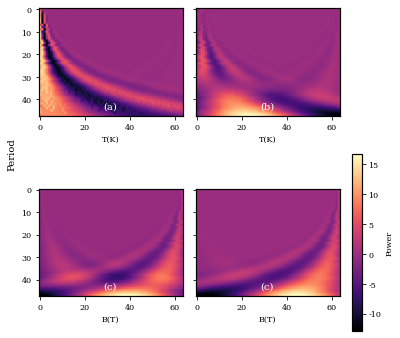

In [16]:
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from matplotlib import ticker

susc = np.array(out[2])[:,:,1]
s_heat = np.array(out[1])[:,:,1]
low_mag = np.array(out[3])[:,:,0,2]
mid_mag = np.array(out[3])[:,:,1,2]

s_x = np.linspace(1, 300, 64)
mag_x = np.linspace(1, 10, 64)
scale = [1.09051, 1.18921, 1.29684, 1.41421, 1.54221, 1.68179, 1.83401, 2., \
2.18102, 2.37841, 2.59368, 2.82843, 3.08442, 3.36359, 3.66802, 4., \
4.36203, 4.75683, 5.18736, 5.65685, 6.16884, 6.72717, 7.33603, 8., \
8.72406, 9.51366, 10.3747, 11.3137, 12.3377, 13.4543, 14.6721, 16., \
17.4481, 19.0273, 20.7494, 22.6274, 24.6754, 26.9087, 29.3441, 32., \
34.8962, 38.0546, 41.4989, 45.2548, 49.3507, 53.8174, 58.6883, 64.]
levels = [0.06125, 0.125, 0.25, 0.5, 1, 2, 4, 8]
contourlevels = np.log2(levels)
wave = 'morl'

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Palatino'] + plt.rcParams['font.serif']
plt.rc('axes', linewidth=1.2)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
# plt.tight_layout()
print(scale)
[susc_coeff, susc_freq] = pywt.cwt(susc.squeeze(), scale, wave, 1)
susc_power = susc_coeff
susc_period = 1. / susc_freq

[sheat_coeff, sheat_freq] = pywt.cwt(s_heat.squeeze(), scale, wave, 1)
sheat_power = sheat_coeff
sheat_period = 1. / sheat_freq

[low_coeff, low_freq] = pywt.cwt(low_mag.squeeze(), scale, wave, 1)
low_power = low_coeff
low_period = 1. / low_freq
 
[mid_coeff, mid_freq] = pywt.cwt(mid_mag.squeeze(), scale, wave, 1)
mid_power = mid_coeff
mid_period = 1. / mid_freq

fig, ax = plt.subplots(ncols=2, nrows=2, sharey=True, figsize=(5.25,5), constrained_layout=True)
fig.text(-0.03, 0.5, 'Period', va='center', rotation='vertical')

susc_plot = ax[0,0].imshow(susc_power, cmap=plt.cm.magma)
ax[0,0].set_xlabel('T(K)')
sheat_plot = ax[0,1].imshow(sheat_power, cmap=plt.cm.magma)
ax[0,1].set_xlabel('T(K)')
low_mag_plot = ax[1,0].imshow(low_power, cmap=plt.cm.magma)
ax[1,0].set_xlabel('B(T)')
mid_mag_plot = ax[1,1].imshow(mid_power, cmap=plt.cm.magma)
ax[1,1].set_xlabel('B(T)')

cb = fig.colorbar(mid_mag_plot, ax=[ax[1,1]], location="right", format=ticker.FormatStrFormatter("%d"))
cb.ax.set_ylabel('Power', fontsize=8)

fig.text(0.45, 0.07, "(a)", transform=ax[0,0].transAxes, c='w')
fig.text(0.45, 0.07, "(b)", transform=ax[0,1].transAxes, c='w')
fig.text(0.45, 0.07, "(c)", transform=ax[1,0].transAxes, c='w')
fig.text(0.45, 0.07, "(c)", transform=ax[1,1].transAxes, c='w')

# plt.savefig('cwt.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()


In [6]:
# http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

# x axis is time (temperature or magnetization)
# y axis is period (1 / frequency) 
# color is power (related to the cwt coefficients)

# scale is related to how detailed different frequencies can be

In [9]:
plt.plot(np.linspace(1, 300, 64), spec.squeeze())

NameError: name 'spec' is not defined

In [10]:
print(targets_df)

           0         1
0  33.641525 -0.841041


In [8]:
from wavelets import WaveletAnalysis
wa = WaveletAnalysis(susc.squeeze(), dt=4.74603175)
# wavelet power spectrum
power = wa.wavelet_power

# scales 
scales = wa.scales

# associated time vector
t = wa.time

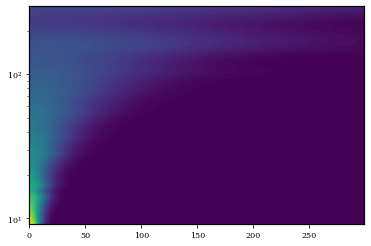

In [9]:
fig, ax = plt.subplots()
T, S = np.meshgrid(t, scales)
ax.contourf(T, S, power, 100)
ax.set_yscale('log')